# KOSPI 변동성 예측
- LSTM

In [99]:
# ! pip install yfinance

In [100]:
# ! pip install arch

https://diane-space.tistory.com/331

# 라이브러리 불러오기

In [101]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [102]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import seaborn as sns
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300


# 데이터 불러오기

In [103]:
df = pd.read_csv("kospi.csv")

In [104]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983
1,2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976
2,2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022
3,2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012
4,2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971


In [105]:
df.shape

(4657, 7)

In [106]:
df = df.set_index('Date')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-01-02,637.099976,623.750000,633.030029,635.169983,742900.0,635.169983
2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976
2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022
2003-01-07,679.299988,652.140015,679.000000,652.200012,690100.0,652.200012
2003-01-08,660.390015,650.929993,655.969971,651.719971,604900.0,651.719971


### VIX 구하기(Volatility)

In [107]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)


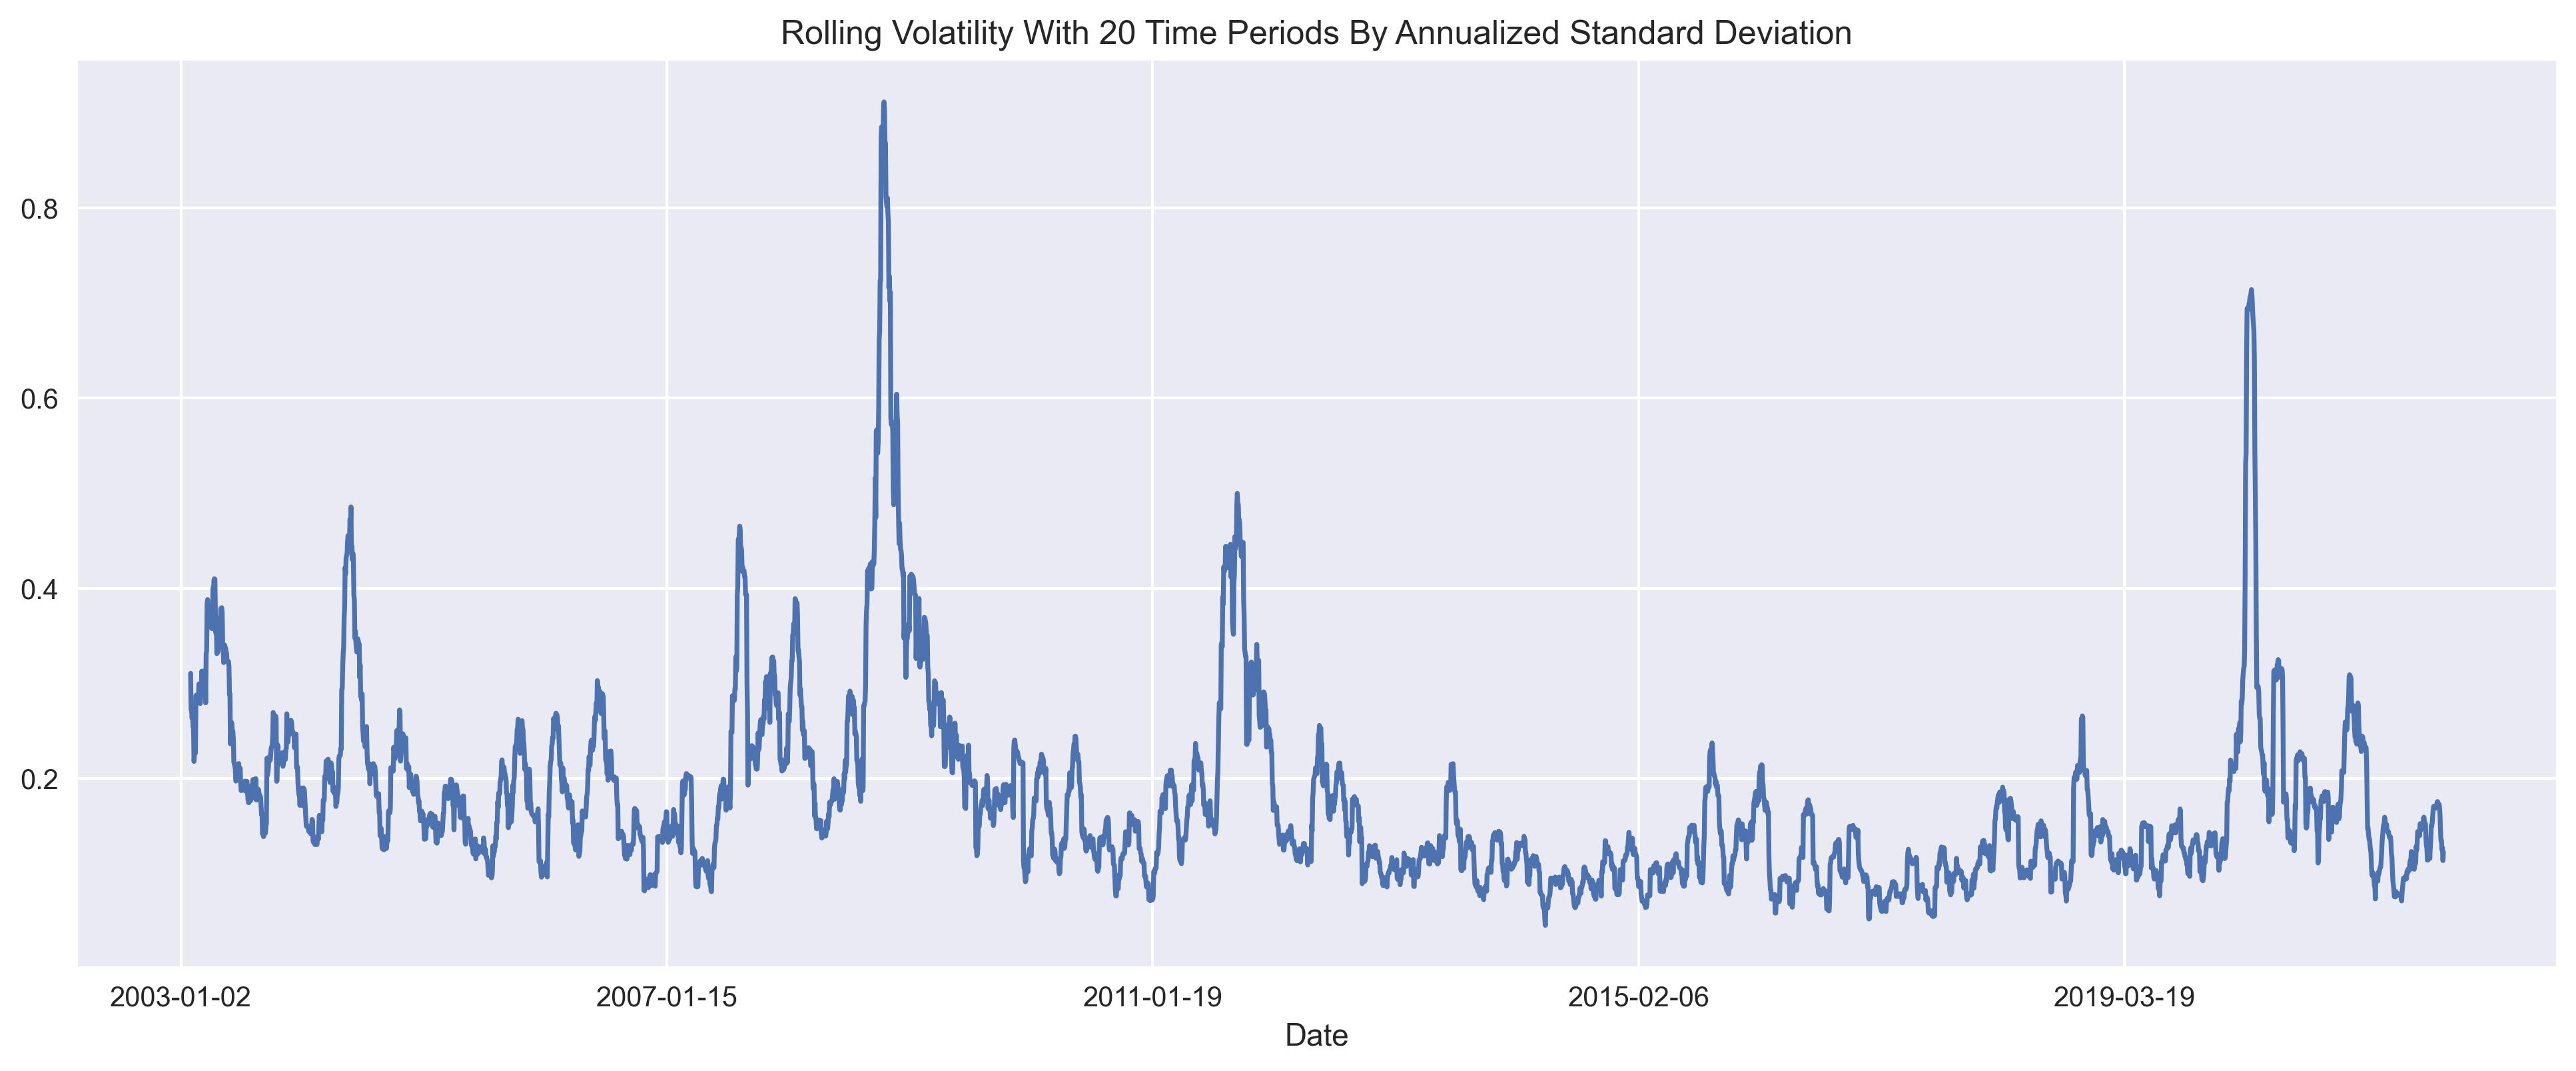

In [108]:
plt.figure(figsize=(16,6))
df['HV'].plot()
plt.title("Rolling Volatility With 20 Time Periods By Annualized Standard Deviation")
plt.show()

In [109]:
df =df.loc['2003-09-29':'2021-09-28']

In [110]:
df.shape

(4444, 10)

In [111]:
df

,High,Low,Open,Close,Volume,Adj Close,Change,STDEV,STDEV_log,HV
Date,,,,,,,,,,
2003-09-29,698.770020,688.070007,697.260010,696.059998,380000.0,696.059998,-0.001921,24.124472,3.183227,0.218297
2003-09-30,709.159973,697.520020,701.750000,697.520020,461300.0,697.520020,0.002098,26.250174,3.267673,0.218889
2003-10-01,704.289978,688.619995,690.469971,704.289978,434300.0,704.289978,0.009706,27.269902,3.305784,0.219563
2003-10-02,718.359985,708.030029,716.270020,715.239990,451400.0,715.239990,0.015548,27.224549,3.304119,0.227551
2003-10-06,726.770020,719.330017,723.469971,723.130005,393300.0,723.130005,0.011031,26.583629,3.280296,0.232149
...,...,...,...,...,...,...,...,...,...,...
2021-09-17,3142.129883,3112.510010,3127.750000,3140.510010,587500.0,3140.510010,0.003329,32.004813,3.465886,0.129747
2021-09-23,3131.629883,3107.979980,3123.639893,3127.580078,623000.0,3127.580078,-0.004117,29.257311,3.376130,0.127155
2021-09-24,3146.860107,3119.399902,3140.729980,3125.239990,752800.0,3125.239990,-0.000748,29.761260,3.393208,0.114283


# Model

## LSTM
__Firstly it is necessary to forecast volatility by the real rolling volatilities to be able to measure the performance two different models alone.__

In [112]:
df.shape

(4444, 10)

# 임의의 학습데이터와 라벨데이터 만들기

In [113]:
training_set = df.iloc[:, 9:10].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(20, df.shape[0]):
    X_train.append(training_set[i-20:i,0])
    y_train.append(training_set[i,0])

In [117]:
X_train, y_train = np.array(X_train), np.array(y_train)

## test 데이터 만들기

In [118]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05)

print(df.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4444, 10) (4202, 20) (222, 20) (4202,) (222,)


In [119]:
y_train = y_train.reshape(y_train.shape[0],1)
y_train.shape

(4202, 1)

In [120]:
y_val = y_val.reshape(y_val.shape[0],1)
y_val.shape

(222, 1)

In [121]:
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
X_val.shape

(222, 20, 1)

### LSTM 에 데이터 넣어주기 위한 Reshape

In [122]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [123]:
X_train.shape

(4202, 20, 1)

In [124]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [125]:
# 2층-양방항 구조의 LSTM 모델을 생성한다.
K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
xLstm_1 = LSTM(10, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
xOutput = Dense(1)(xLstm_2)

In [126]:
model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam')

In [ ]:
# # 2층-양방항 구조의 LSTM 모델을 생성한다.
# K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
# model = Sequential()
# model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
# # xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
# model.add(Dense(units = 1))

# # xLstm_1 = LSTM(10, return_sequences = True)(xInput)
# # xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
# # xOutput = Dense(1)(xLstm_2)

In [127]:
# 학습
history = model.fit(X_train, y_train, validation_data =(X_val, y_val), epochs=5, batch_size=20, verbose=1)

Epoch 1/5
211/211 [==============================] - 8s 19ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 2/5
211/211 [==============================] - 3s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/5
211/211 [==============================] - 3s 15ms/step - loss: 7.9331e-04 - val_loss: 9.2176e-04
Epoch 4/5
211/211 [==============================] - 3s 14ms/step - loss: 6.5363e-04 - val_loss: 9.7416e-04
Epoch 5/5
211/211 [==============================] - 3s 15ms/step - loss: 5.8769e-04 - val_loss: 6.6803e-04


In [129]:
y_train = y_train.reshape(y_train.shape[0],1)
y_train.shape

(4202, 1)

In [130]:
y_val = y_val.reshape(y_val.shape[0],1)
y_val.shape

(222, 1)

In [131]:
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
X_val.shape

(222, 20, 1)

In [132]:
val_loss = history.history['val_loss']
print(val_loss[:5])

[0.0031198246870189905, 0.0013844378991052508, 0.000921764352824539, 0.0009741571266204119, 0.0006680287187919021]


In [133]:
train_loss = history.history['loss']
print(train_loss[:5])

[0.005647154059261084, 0.0016216003568843007, 0.0007933136075735092, 0.0006536325090564787, 0.0005876928335055709]


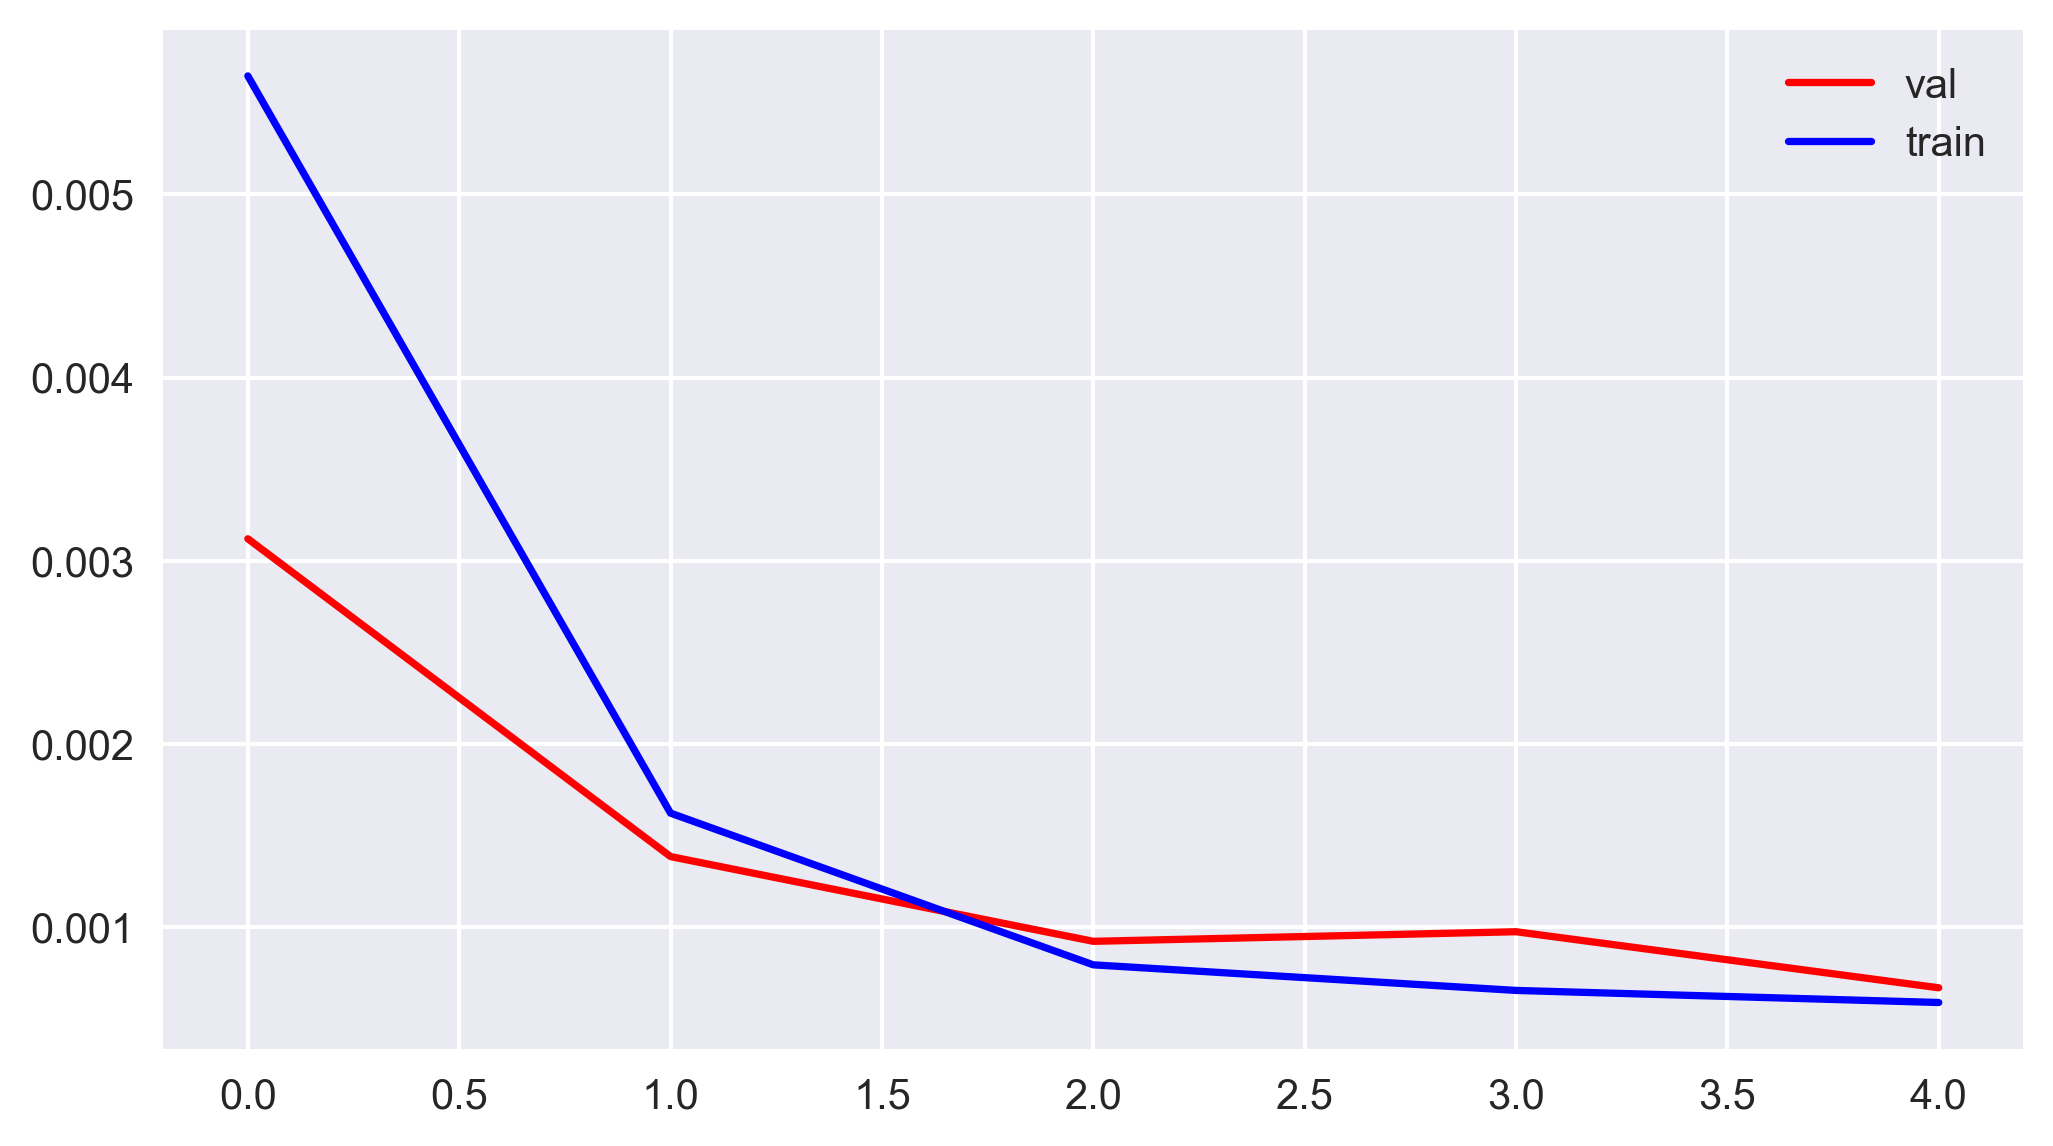

In [134]:
plt.plot(np.arange(len(val_loss)), val_loss, c="red", label='val')
plt.plot(np.arange(len(train_loss)), train_loss, c='blue', label ='train')
plt.legend()
plt.show()

# 예측 결과 시각화
- https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=chunjein&logNo=221589705745&widgetTypeCall=true


In [135]:
# 예측
y_hat = model.predict(X_val, batch_size=1)

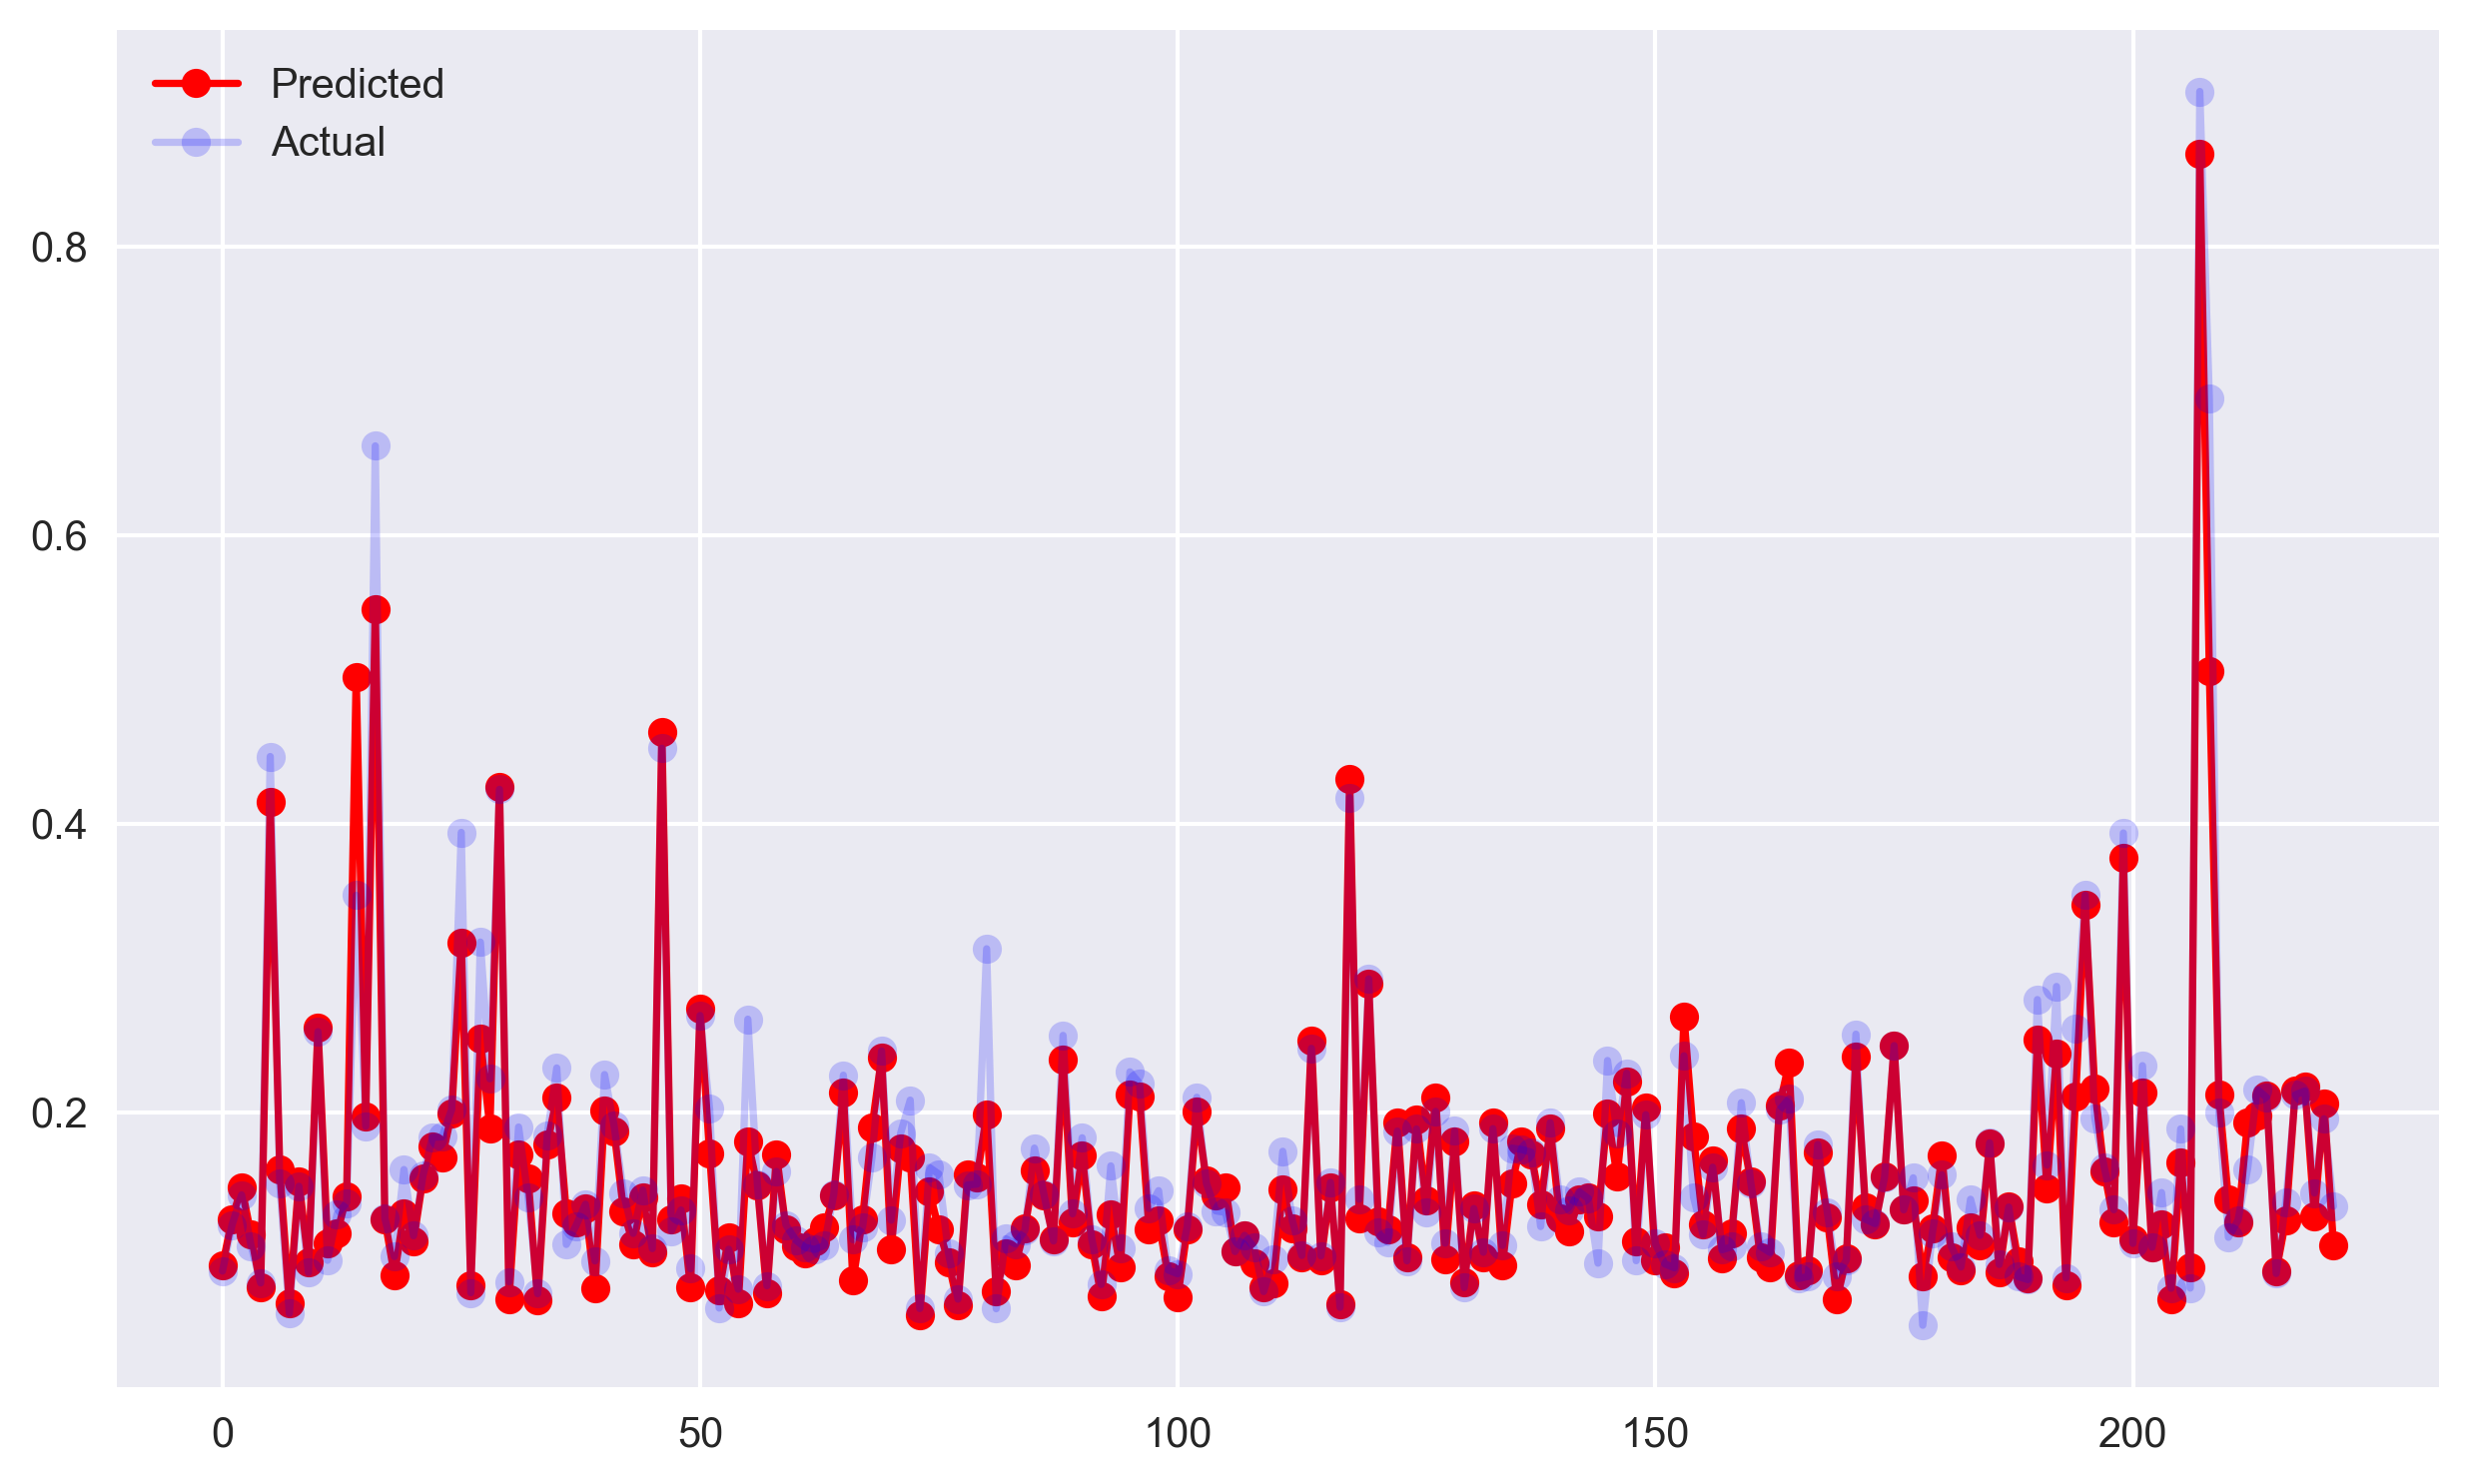

In [137]:
a_axis = np.arange(0,y_train.shape[0])
# b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))
b_axis = np.arange(0, y_val.shape[0])
plt.figure(figsize=(10,6))
# plt.plot(a_axis, y_train.reshape(len(y_train),), 'o-')
plt.plot(b_axis, y_hat.reshape(y_hat.shape[0],), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_val.reshape(y_val.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
plt.legend()
plt.show()

In [138]:
rmse_lstm = np.sqrt(history.history["val_loss"])
rmse_lstm[:5]

array([0.05585539, 0.03720804, 0.03036057, 0.03121149, 0.02584625])

In [139]:
score_lstm = np.mean(rmse_lstm)
score_lstm

0.03609634808822286

# GRU

In [140]:
# create a model 
from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN, GRU

In [90]:
# # The GRU architecture 
# my_GRU_model = Sequential()
# my_GRU_model.add(GRU(units = 50, 
#                      return_sequences = True, 
#                      input_shape = (X_train.shape[1],1), 
#                      activation = 'tanh'))
# my_GRU_model.add(GRU(units = 50, 
#                      activation = 'tanh'))
# my_GRU_model.add(Dense(units = 2))

In [94]:
# # Compiling the RNN 
# my_GRU_model.compile(optimizer = 'adam', 
#                      loss = 'mean_squared_error')

In [91]:
# # 2층-양방항 구조의 LSTM 모델을 생성한다.
# K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
# xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
# xLstm_1 = LSTM(10, return_sequences = True)(xInput)
# xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
# xOutput = Dense(1)(xLstm_2)

In [141]:
# 2층-양방항 구조의 LSTM 모델을 생성한다.
K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
xgru_1 = GRU(10, return_sequences = True)(xInput)
xOutput = Dense(1)(xgru_1)

In [142]:
my_GRU_model = Model(xInput, xOutput)
my_GRU_model.compile(loss='mse', optimizer='adam')

In [143]:
# Fitting to the trainig set
# 학습
history_gru = my_GRU_model.fit(X_train, y_train, validation_data =(X_val, y_val),epochs = 5, batch_size = 20, verbose = 1)


Epoch 1/5
211/211 [==============================] - 4s 9ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 2/5
211/211 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 3/5
211/211 [==============================] - 2s 8ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 4/5
211/211 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 5/5
211/211 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0040


In [144]:
val_loss_gru = history_gru.history['val_loss']
print(val_loss_gru[:5])

[0.004847627133131027, 0.0041707661002874374, 0.004021375440061092, 0.003997721243649721, 0.0039980229921638966]


In [145]:
train_loss_gru = history_gru.history['loss']
print(train_loss_gru[:5])

[0.008088703267276287, 0.003506100969389081, 0.0032155050430446863, 0.003115334315225482, 0.003041307907551527]


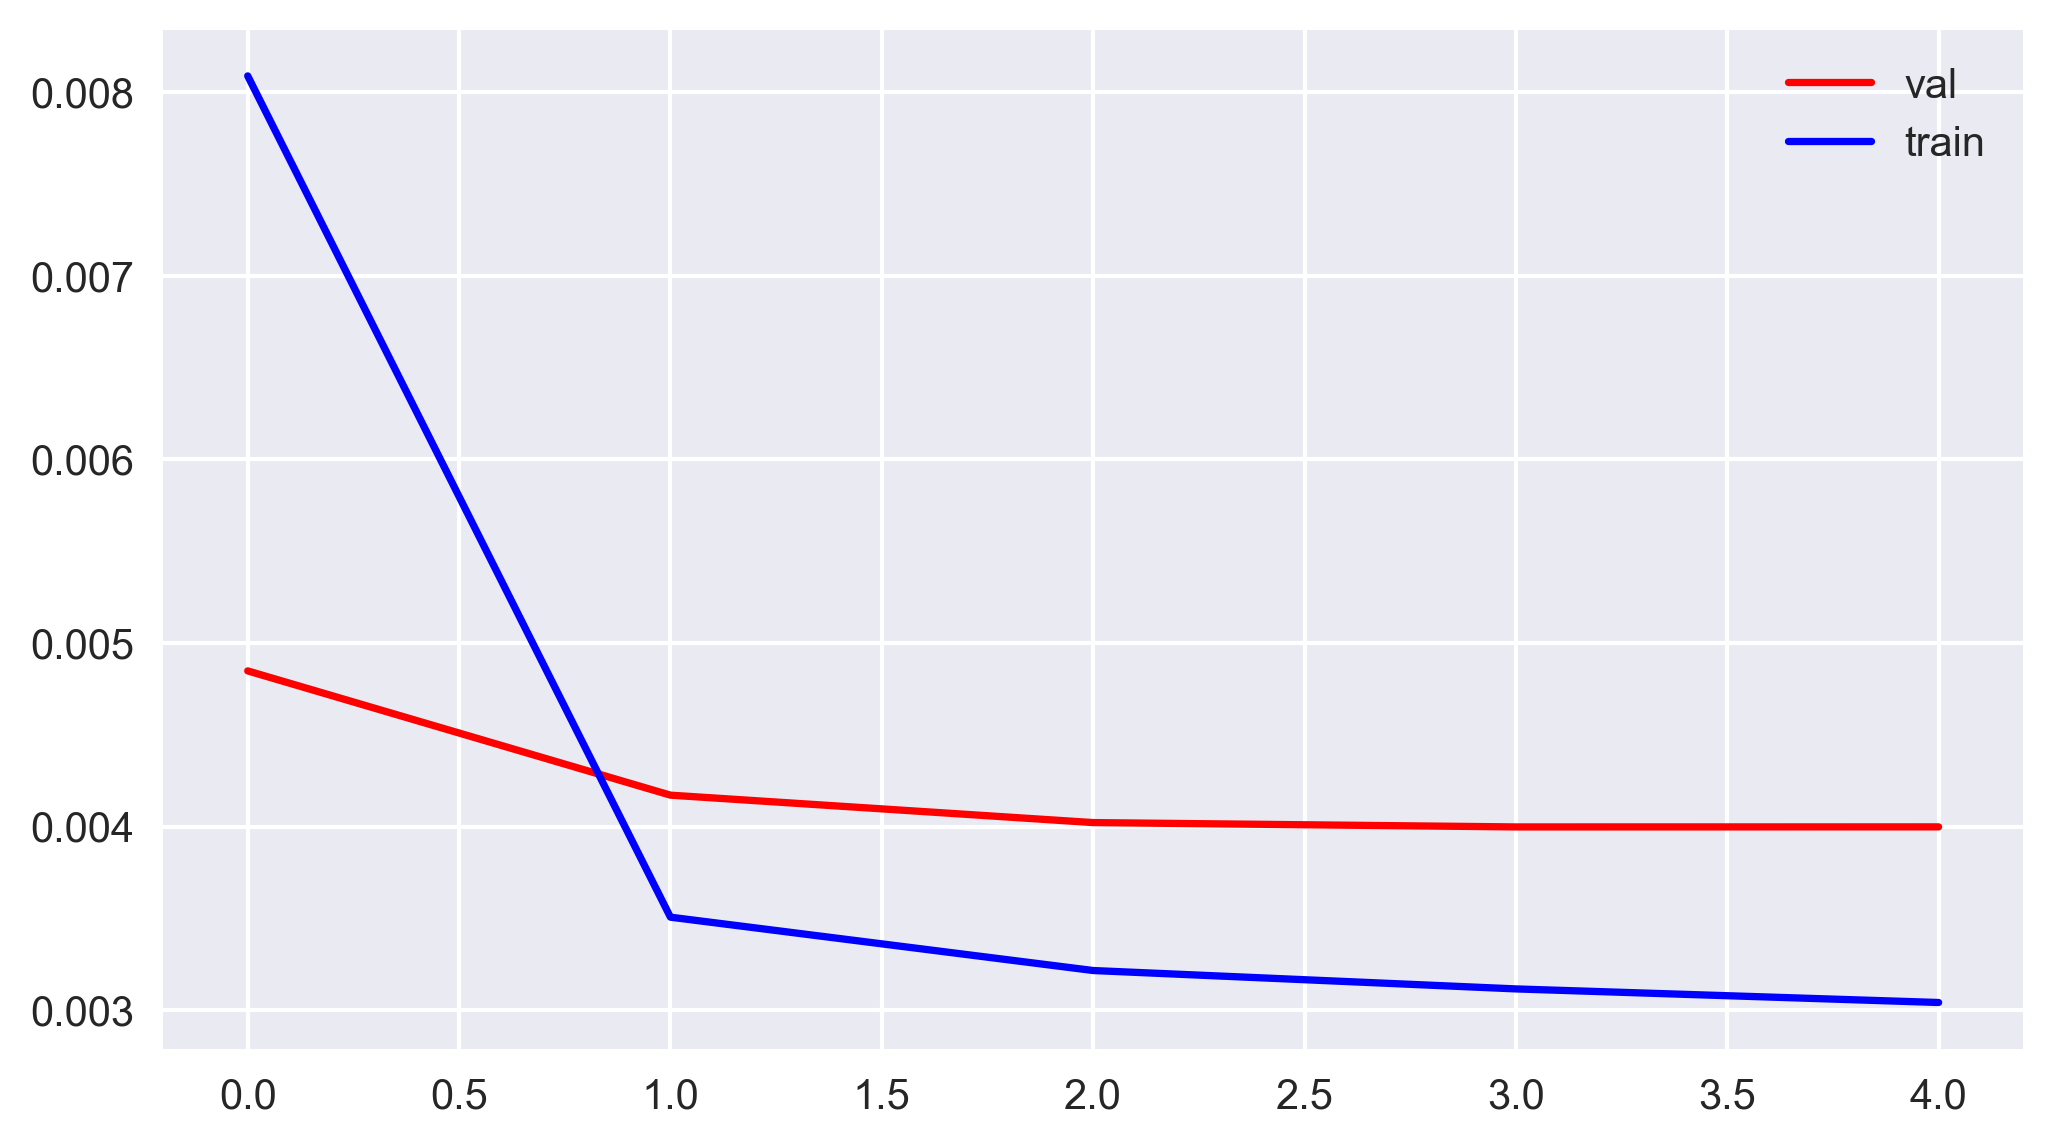

In [146]:
plt.plot(np.arange(len(val_loss_gru)), val_loss_gru, c="red", label='val')
plt.plot(np.arange(len(train_loss_gru)), train_loss_gru, c='blue', label ='train')
plt.legend()
plt.show()

# 예측 결과 시각화
- https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=chunjein&logNo=221589705745&widgetTypeCall=true


In [164]:
# 예측
y_hat_gru = my_GRU_model.predict(X_val, batch_size=1)

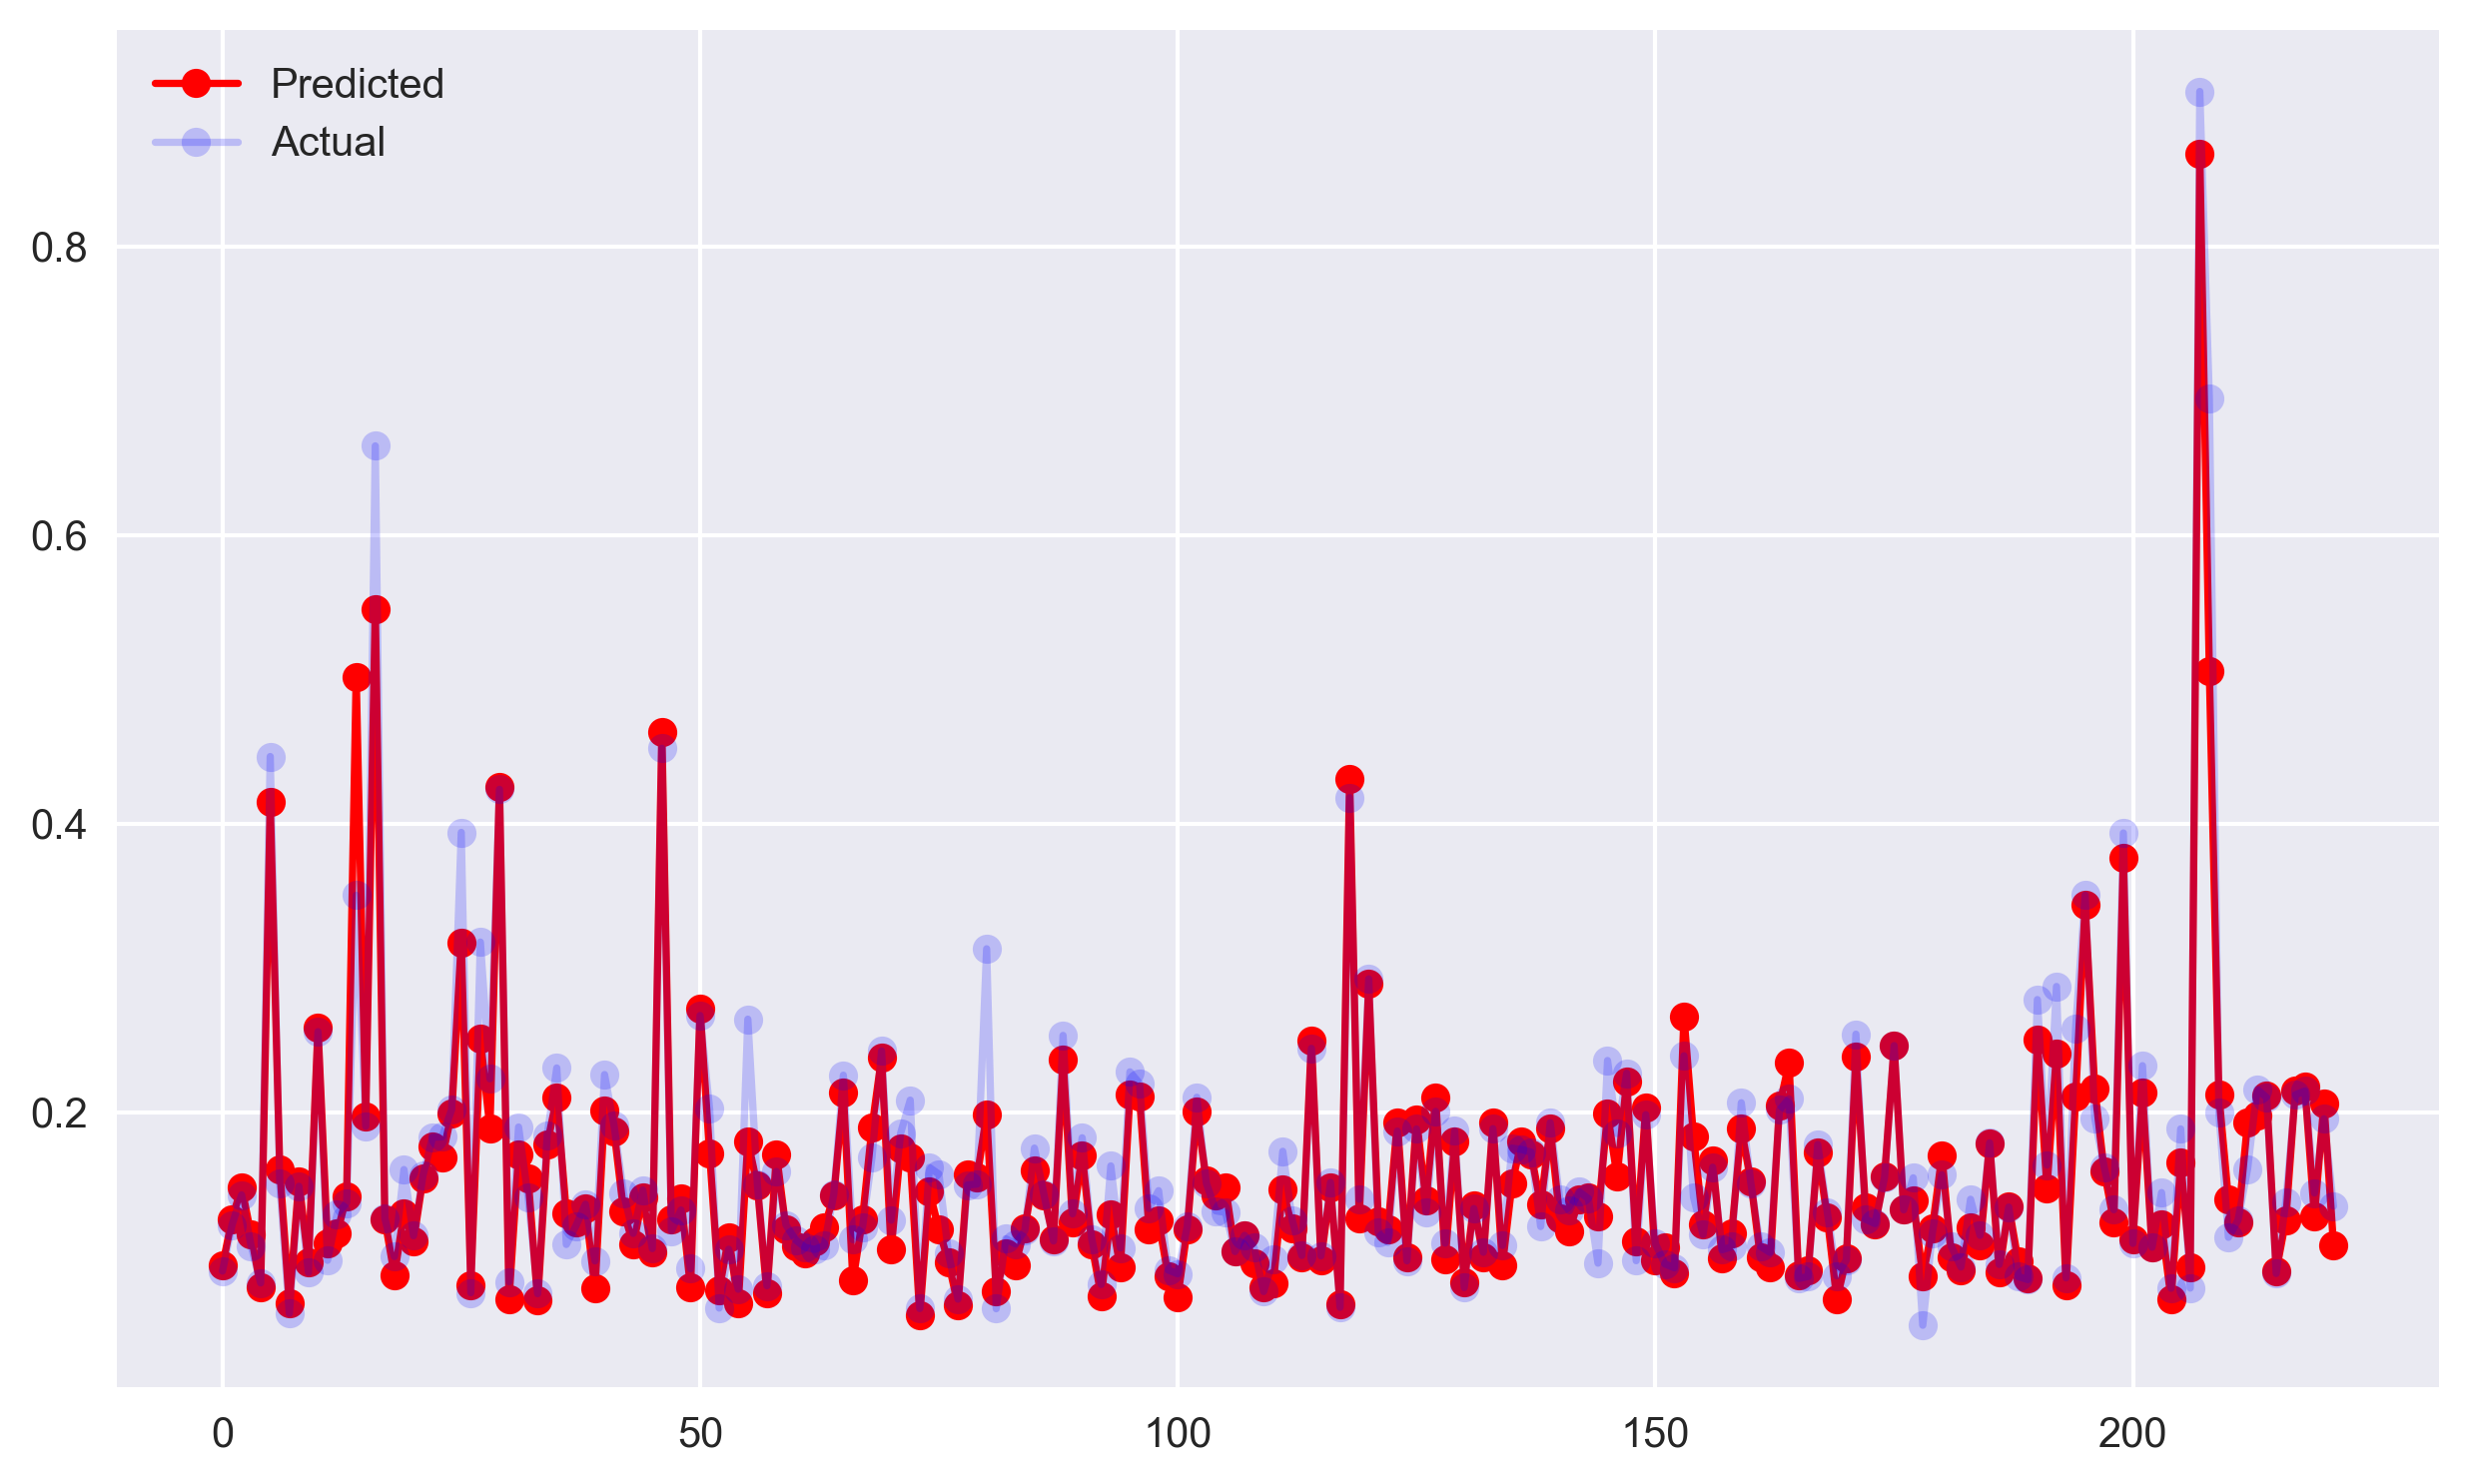

In [163]:
# a_axis = np.arange(0,y_train.shape[0])
# # b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))
# b_axis = np.arange(0, y_val.shape[0])
# plt.figure(figsize=(10,6))
# # plt.plot(a_axis, y_train.reshape(len(y_train),), 'o-')
# plt.plot(b_axis, y_hat_gru.reshape(y_hat_gru.shape[0],), 'o-', color='red', label='Predicted')
# plt.plot(b_axis, y_val.reshape(y_val.shape[0],), 'o-', color='blue', alpha=0.2, label='Actual')
# plt.legend()
# plt.show()

In [150]:
rmse_gru= np.sqrt(history_gru.history["val_loss"])
rmse_gru[:5]

array([0.0696249 , 0.06458147, 0.06341432, 0.06322754, 0.06322992])

In [151]:
score_gru = np.mean(rmse_gru)
score_gru

0.06481562893795252

In [152]:
# 열이름을 key로 하고, 리스트를 value로 갖는 딕셔너리 정의 (2창원 배열)
dict_data = {'HV_RMSE':[score_lstm,score_gru] }
print(dict_data)

# # 판다스 DataFrame() 함수로 딕셔너리를 데이터프레임으로 변환, 변수 df에 저장
df_result = pd.DataFrame(dict_data, index=[['LSTM', 'GRU']])

df_result

{'HV_RMSE': [0.03609634808822286, 0.06481562893795252]}


,HV_RMSE
LSTM,0.036096
GRU,0.064816
